# **Use ML techniques for layer stackup modeling**  
## Table of contents:  
### 1.**[Motivation](#Motivation)**  <a href='#Motivation'>...</a>
### 2.**[Problem Statements](#Problem Statements)**  <a href='#Problem_Statements'>...</a>
### 3.**[Generate Data](#Generate Data)**  <a href='#Generate_Data'>...</a>
### 4.**[Prepare Data](#Prepare Data)**  <a href='#Prepare_Data'>...</a>
### 5.**[Choose a Model](#Choose a Model)**  <a href='#Choose_a_Model'>...</a>
### 6.**[Training](#Training)**  <a href='#Training'>...</a>
### 7.**[Neural Network](#Neural Network)**  <a href='#Neural_Network'>...</a>
### 8.**[Deploy](#Deploy)**  <a href='#Deploy'>...</a>
### 9.**[Conclusion](#Conclusion)**  <a href='#Conclusion'>...</a>

## **Motivation:**<a id = 'Motivation'></a>

When planning a PCB layer stackup, often time we would like to know the trade-off between various layout options vs their signal integrity performance. For example, a wider trace may provides smaller impedance yet occupate more routing area. Narrow down the spacing between differential pairs may save some spaces but will also increase crosstalk. Most EDA tool involving system level signal integrity analysis provides "transmission line calculator" like shown below for designer to quickly make estimation and determine the trade-off:  
![TLineCalc](https://github.com/SPISim/ML_LStkModeling/blob/master/assets/images/KiCad_LineCalc.png)

However, all such "calculators" I have seen, even in a commercial one, only consider the single trace or one differential pair itself. They do not take take crosstalks into account. More over, stackup parameters such as conductivity and permetivity must be entered individually instead of a range. As a results, user can't not easily visualize relationships between performance parameters vs the stackup properties. Thus, an enhanced version of such "T-Line calculator", which can address the aformentioned gaps will be very useful. Such tool requires a prediction model to link between various stackup parameters to their performance targets. Data science/machine learning techniques can thus be used to build such model.

## **Problem Statements:**<a id = 'Problem_Statements'></a>

We would like to build a prediction model such that given a set of stackup parameters such as trace width and spacing etc, its performance such as impedance, attenuations, near-end and far-end crosstalk can be quickly estimated. This model can then be deployed into a stand-alone tool for range based sweep such that a visual plot can be generated to provide relations between various parameters to decide design trade-off.

## **Generate Data**:<a id = 'Generate_Data'></a>

### Overview:   
The model to be built here is for nominal (i.e. numerical) prediction with around 10 attributes, i.e. input variables. Various stackup configurations will be generated via sampling and their corresponding stackup model, in the form of frequency dependent R/L/G/C matrices will be simulated via field solver. Such process are deterministics. Post process steps will read these solved model and calculate performance. Here we define performance to be predicted as impedance, attenuation, near-end/far-end crosstalks and propagation speed.

### ***Define stakup structure:***   
There are many possible stakup structures as shown below. For more accurate prediction, we are going to generate one prediction model per structure.
![Presets](./assets/images/LStkPresets.png)

Use three single-ended traces (victim in the middle) in strip-line setup as an example, various attributes may be defined as shown below:
![Setup](./assets/images/SLSE3Setup.png)

These parameters, such as S(Spacing), W(Width), Sigma(Conductivity), Er(Permitivity), H(Height) etc are represented as varaibles to be sampled.

### ***Define sampling points:***   
Next step is to define ranges of variable values and sampling points. Since there are about 10 parameters, full combinatorial data will be impractical. Thus we may need to apply sampling algorithms such as design-of-experiments or spacing filling etc to establish best coverage of the solution space.
For this setup, we have generate 10,000 cases to be simulated.
![Sample](./assets/images/SLSE3Sample.png)

### ***Generate inputs setup and simulate:***   
Once we have sample points, layer stackup configurations to the solver to be used will be generated. Each field solver has different syntax thus a flow will be needed...
![TProFlow](./assets/images/SLSE3FlowGUI.png)

In this case, we use HSpice from Synopsys for field solver, thus each of 10K parameter combinations will be used to generate their spice input files for simulation:
![Simulate](./assets/images/SLSE3Simulate.png)

The next step is to perforam circuit simulation for all these cases. This may be a time-consuming process so a distributed environment or simulation farm may be used.

### ***Performance measurement:***   
The outcome of each simulation is a frequency dependent tabular model, corresponding to its layer stackup settings. HSpice's tabular format looks like this:
![Tabular](./assets/images/SLSE3Tabular.png)
Next step is to load these models and do performance measurement:
![Measure](./assets/images/SLSE3Measure.png)
Matrix manipulation such as eigen-value decomponsition will be applied in order to obtain the characteristic impedance and propagation speed etc. Measurement output of each model should be a set of parameters which will be combined with original inputs to form the dataset for our prediction modeling.

## **Prepare Data:**<a id = 'Prepare_Data'></a>
From this point, we can start the modeling process using python and various packages.

In [101]:
%matplotlib inline

## Initial set-up for data
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

prjHome = 'C:/Temp/WinProj/LStkMdl'
workDir = prjHome + '/wsp/'
srcFile = prjHome + '/dat/SLSE3.csv'

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(workDir, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [102]:
# Let's read the data and do some statistic
srcData = pd.read_csv(srcFile)

# Take a peek:
srcData.head()

,H1,H3,ER1,ER3,TD1,TD3,H2,W,S,EDW,SIGMA,H,FNAME,Z0SE(1_SE),S0SE(1_SE),KBSENB(1_1),KFSENB(1_1),A(1_1)
0,4.9311,5.5859,3.6964,3.3277,0.013771,0.030565,0.91236,7.5573,30.6610,0.177530,50000000.0,15,SPIMDL00001.TAB,37.715088,1.601068e+08,0.000035,-7.297762e-15,0.497289
1,4.8918,5.3156,4.0410,3.8404,0.022008,0.008600,0.53126,7.0378,6.9217,0.733370,50000000.0,15,SPIMDL00002.TAB,39.831954,1.510345e+08,0.019608,-1.093612e-12,0.249591
2,1.7907,11.5230,3.6984,3.3534,0.013859,0.045137,2.00990,3.6964,27.3230,0.707750,50000000.0,15,SPIMDL00003.TAB,35.663928,1.587798e+08,0.000305,-2.797417e-13,0.705953
3,2.8595,4.7259,3.9605,3.3981,0.010481,0.018028,0.36547,2.3872,7.2803,0.735210,50000000.0,15,SPIMDL00004.TAB,59.456438,1.558444e+08,0.010125,-5.478920e-12,0.327952
4,5.5946,8.2553,3.4176,3.3249,0.024434,0.003663,2.08810,6.3776,20.1680,0.053585,50000000.0,15,SPIMDL00005.TAB,46.082722,1.633106e+08,0.004136,-4.787903e-13,0.169760


In [103]:
srcData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
H1             10000 non-null float64
H3             10000 non-null float64
ER1            10000 non-null float64
ER3            10000 non-null float64
TD1            10000 non-null float64
TD3            10000 non-null float64
H2             10000 non-null float64
W              10000 non-null float64
S              10000 non-null float64
EDW            10000 non-null float64
SIGMA          10000 non-null float64
H              10000 non-null int64
FNAME          10000 non-null object
Z0SE(1_SE)     10000 non-null float64
S0SE(1_SE)     10000 non-null float64
KBSENB(1_1)    9998 non-null float64
KFSENB(1_1)    9998 non-null float64
A(1_1)         10000 non-null float64
dtypes: float64(16), int64(1), object(1)
memory usage: 1.4+ MB


In [104]:
srcData.describe()

,H1,H3,ER1,ER3,TD1,TD3,H2,W,S,EDW,SIGMA,H,Z0SE(1_SE),S0SE(1_SE),KBSENB(1_1),KFSENB(1_1),A(1_1)
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.0,10000.000000,1.000000e+04,9.998000e+03,9.998000e+03,10000.000000
mean,4.199999,7.500007,3.850001,3.850001,0.025000,0.025000,1.400000,5.500001,18.500007,0.375000,50000000.0,15.0,42.985345,1.533140e+08,1.475118e-02,-2.155868e-12,0.509534
std,1.616661,3.175591,0.490773,0.490772,0.014434,0.014434,0.635117,2.020829,9.526750,0.216515,0.0,0.0,172.163835,7.085288e+06,2.847164e-02,3.787910e-11,0.288974
min,1.400000,2.001000,3.000000,3.000100,0.000003,0.000002,0.300140,2.000100,2.002600,0.000002,50000000.0,15.0,11.630424,1.384625e+08,1.009146e-10,-2.796522e-09,0.011486
25%,2.799925,4.750325,3.425075,3.425050,0.012500,0.012501,0.850038,3.750350,10.250000,0.187510,50000000.0,15.0,32.173933,1.479284e+08,2.216767e-04,-1.112024e-12,0.328938
50%,4.200000,7.500500,3.850000,3.849950,0.025000,0.025000,1.399950,5.500150,18.500000,0.374985,50000000.0,15.0,40.031614,1.527750e+08,1.969018e-03,-1.928585e-15,0.507237
75%,5.600075,10.249500,4.274950,4.274950,0.037499,0.037498,1.949875,7.249650,26.748000,0.562507,50000000.0,15.0,48.688036,1.583456e+08,1.376321e-02,7.447876e-13,0.680500
max,6.999900,13.000000,4.699800,4.699900,0.050000,0.049995,2.500000,8.999600,34.999000,0.749930,50000000.0,15.0,17097.973570,1.725066e+08,3.184933e-01,9.613918e-11,14.524624


### ** Note that:**  
- Sigma(Conductivity) and H(default layer height) are constants in this setup;
- FNAME (File name) is not needed for modeling
- Z0 (impedance) has outliers
- Forward/Backward crosstalk (Kb/kf) have missing terms

In [105]:
# drop constant and file name columns
stkData = srcData.drop(columns=['H', 'SIGMA', 'FNAME'])

Saving figure attribute_histogram_plots


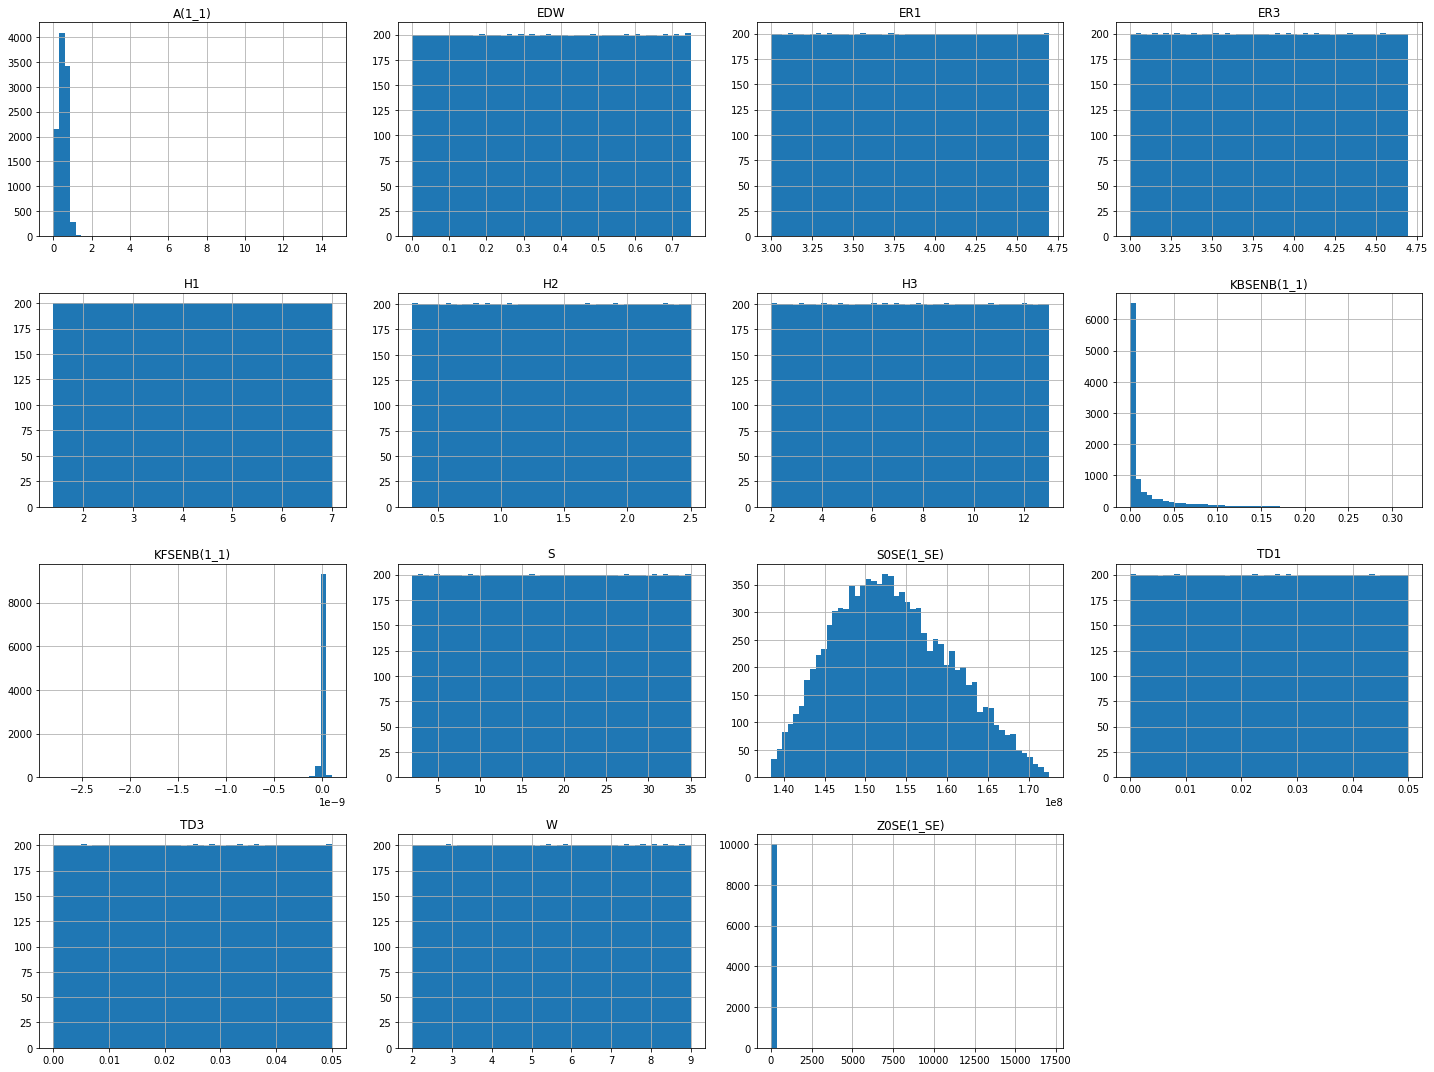

In [106]:
# plot distributions before dropping measurement outliers
stkData.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [107]:
# drop outliers and invalid Kb/Kf cells
# These may be caused by unphysical stakup model or calculation during post-processing
maxZVal = 200
minZVal = 10
stkTemp = stkData[(stkData['Z0SE(1_SE)'] < maxZVal) & \
                  (stkData['Z0SE(1_SE)'] > minZVal) & \
                  (np.abs(stkData['KBSENB(1_1)']) > 0.0) & \
                  (np.abs(stkData['KFSENB(1_1)']) > 0.0)]

# Check again to make sure data are now justified
stkTemp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9994 entries, 0 to 9999
Data columns (total 15 columns):
H1             9994 non-null float64
H3             9994 non-null float64
ER1            9994 non-null float64
ER3            9994 non-null float64
TD1            9994 non-null float64
TD3            9994 non-null float64
H2             9994 non-null float64
W              9994 non-null float64
S              9994 non-null float64
EDW            9994 non-null float64
Z0SE(1_SE)     9994 non-null float64
S0SE(1_SE)     9994 non-null float64
KBSENB(1_1)    9994 non-null float64
KFSENB(1_1)    9994 non-null float64
A(1_1)         9994 non-null float64
dtypes: float64(15)
memory usage: 1.2 MB


Saving figure attribute_histogram_plots


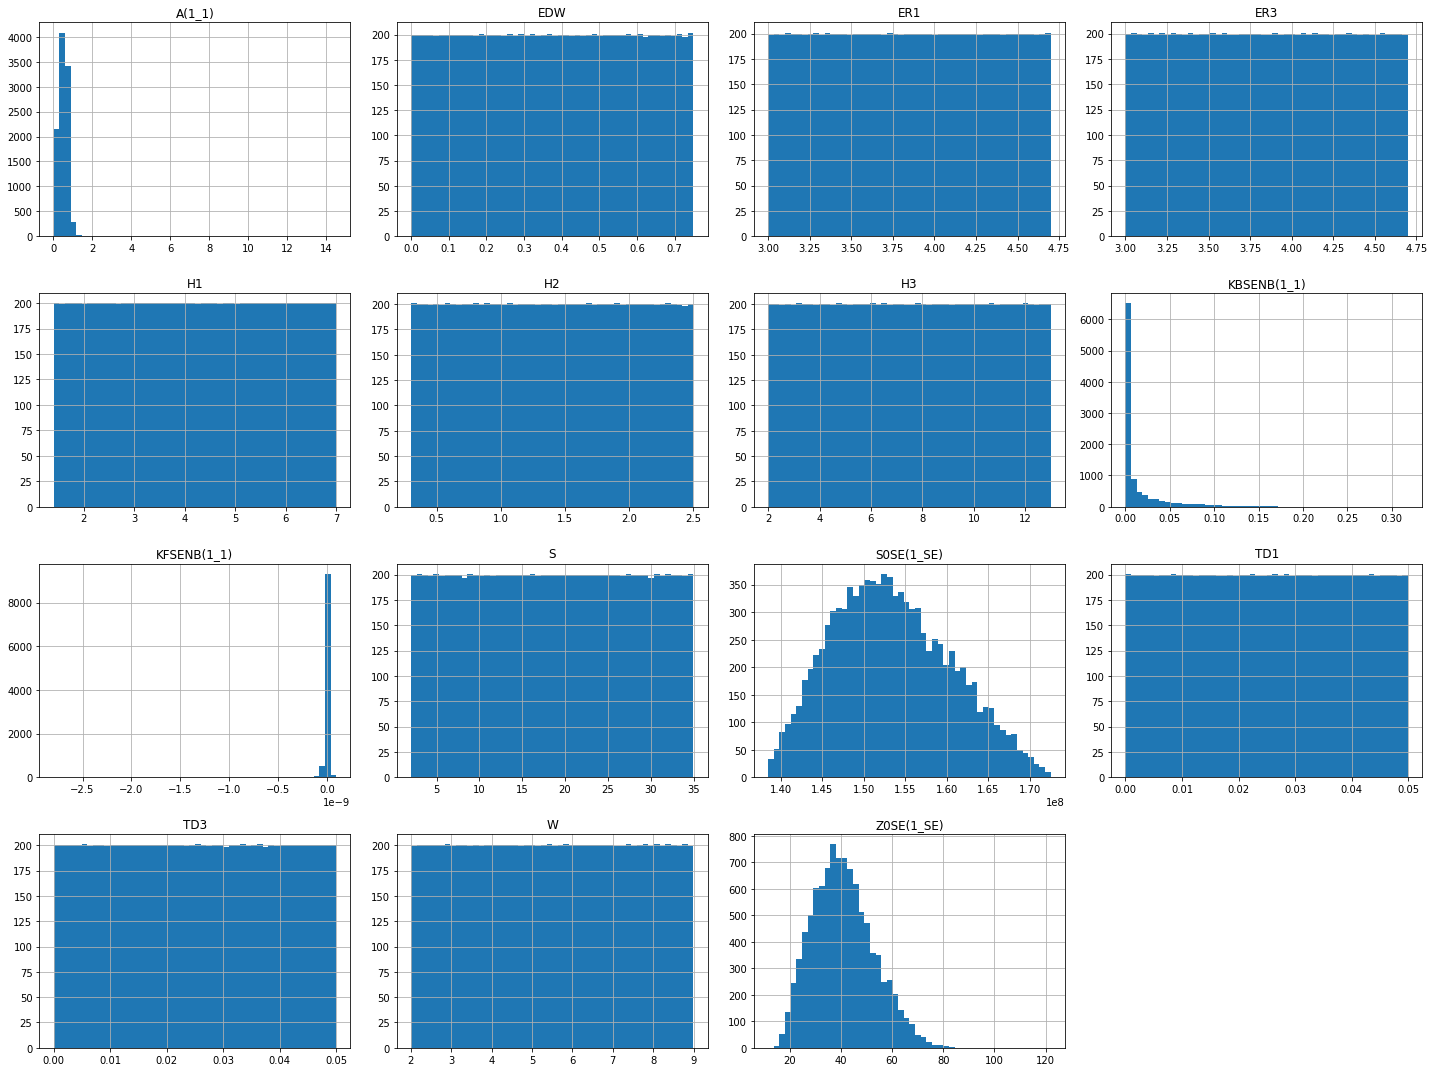

In [108]:
# now plot distributions again, should see proper distribuition now
stkData = stkTemp
stkData.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [109]:
# find principal components for Z
corr_matrix = stkData.drop(columns=['KBSENB(1_1)', 'KFSENB(1_1)', 'S0SE(1_SE)', 'A(1_1)']).corr()
corr_matrix['Z0SE(1_SE)'].abs().sort_values(ascending=False)

Z0SE(1_SE)    1.000000
W             0.664396
H1            0.535432
H3            0.344356
H2            0.186618
ER1           0.119390
ER3           0.110507
EDW           0.067261
TD3           0.061906
TD1           0.017937
S             0.000107
Name: Z0SE(1_SE), dtype: float64

From this correlation matrix above, it can be shown that trace width and height are dominate factors for the trace's impedance.

## **Choose a Model:**<a id = 'Choose_a_Model'></a>

Since we are building a nominal estimator here, I will try simple linear regressor as estimator first:

In [110]:
# Separate input and output attributes
allTars = ['Z0SE(1_SE)', 'KBSENB(1_1)', 'KFSENB(1_1)', 'S0SE(1_SE)', 'A(1_1)']
varList = [e for e in list(stkData) if e not in allTars]
varData = stkData[varList]

In [111]:
# We have 10,000 cases here, try in-memory normal equation directly first:

# LinearRegression Fit Impedance
from sklearn.linear_model import LinearRegression

tarData = stkData['Z0SE(1_SE)']
lin_reg = LinearRegression()
lin_reg.fit(varData, tarData)

# Fit and check predictions using MSE etc
from sklearn.metrics import mean_squared_error, mean_absolute_error
predict = lin_reg.predict(varData)
resRMSE = np.sqrt(mean_squared_error(tarData, predict))
resRMSE

3.478480854776983

In [112]:
# Use 10-Split for cross validations:
def display_scores(attribs, scores):
    print("Attribute:", attribs)
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, varData, tarData,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(varList, lin_rmse_scores)

Attribute: ['H1', 'H3', 'ER1', 'ER3', 'TD1', 'TD3', 'H2', 'W', 'S', 'EDW']
Scores: [3.25291562 4.16881619 3.22429058 3.32251943 3.70096691 3.46812853
 3.34169206 3.5511994  3.28259776 3.39876687]
Mean: 3.4711893352193854
Standard deviation: 0.270957271481177


In [113]:
# try Regularization it self
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(varData, tarData)
predict = ridge_reg.predict(varData)
resRMSE = np.sqrt(mean_squared_error(tarData, predict))
resRMSE

3.4921877809274595

Thus a 3 ohms or so difference may be obtained from this estimator. What if higher order regression is used:

In [114]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
varPoly = poly_features.fit_transform(varData)
lin_reg = LinearRegression()
lin_reg.fit(varPoly, tarData)
predict = lin_reg.predict(varPoly)
resRMSE = np.sqrt(mean_squared_error(tarData, predict))
resRMSE

1.2780298094097002

A more accurate model thus may be obtained this way. 

## **Training and Evaluation:**<a id = 'Training'></a>

Saving figure underfitting_learning_curves_plot


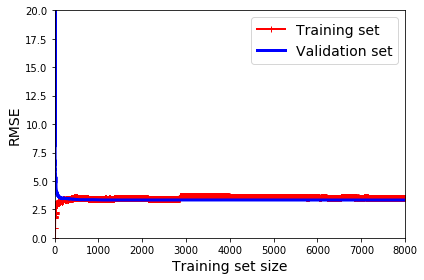

In [115]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="Training set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, varData, tarData)
plt.axis([0, 8000, 0, 20])
save_fig("underfitting_learning_curves_plot")
plt.show()

## **Neural Network:**<a id = 'neural_network'></a>

As the difference between prediction to actual measurement is about two ohms, it has met our modeling goals. As an alternative approacy, let's try neural net modeling below

In [116]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

numInps = len(varList)
nnetMdl = Sequential()
# input layer
nnetMdl.add(Dense(units=64, activation='relu', input_dim=numInps))

# hidden layers
nnetMdl.add(Dropout(0.3, noise_shape=None, seed=None))
nnetMdl.add(Dense(64, activation = "relu"))
nnetMdl.add(Dropout(0.2, noise_shape=None, seed=None))
          
# output layer
nnetMdl.add(Dense(units=1, activation='sigmoid'))
nnetMdl.compile(loss='mean_squared_error', optimizer='adam')

# Provide some info
#from keras.utils import plot_model
#plot_model(nnetMdl, to_file= workDir + 'model.png')
nnetMdl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                704       
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [117]:
# Prepare Training (tran) and Validation (test) dataset
varTran, varTest, tarTran, tarTest = train_test_split(varData, tarData, test_size=0.2)

# scale the data
from sklearn import preprocessing
varScal = preprocessing.MinMaxScaler()
varTran = varScal.fit_transform(varTran)
varTest = varScal.transform(varTest)

tarScal = preprocessing.MinMaxScaler()
tarTran = tarScal.fit_transform(tarTran.values.reshape(-1, 1))

In [118]:
hist = nnetMdl.fit(varTran, tarTran, epochs=50, batch_size=1000, validation_split=0.1)
tarTemp = nnetMdl.predict(varTest, batch_size=1000)
predict = tarScal.inverse_transform(tarTemp)
resRMSE = np.sqrt(mean_squared_error(tarTest, predict))
resRMSE

Train on 7195 samples, validate on 800 samples
Epoch 1/50
7195/7195 [==============================] - 0s 43us/step - loss: 0.0457 - val_loss: 0.0205
Epoch 2/50
7195/7195 [==============================] - 0s 4us/step - loss: 0.0202 - val_loss: 0.0150
Epoch 3/50
7195/7195 [==============================] - 0s 4us/step - loss: 0.0173 - val_loss: 0.0157
Epoch 4/50
7195/7195 [==============================] - 0s 4us/step - loss: 0.0169 - val_loss: 0.0134
Epoch 5/50
7195/7195 [==============================] - 0s 5us/step - loss: 0.0148 - val_loss: 0.0111
Epoch 6/50
7195/7195 [==============================] - 0s 6us/step - loss: 0.0129 - val_loss: 0.0094
Epoch 7/50
7195/7195 [==============================] - 0s 5us/step - loss: 0.0110 - val_loss: 0.0078
Epoch 8/50
7195/7195 [==============================] - 0s 4us/step - loss: 0.0093 - val_loss: 0.0061
Epoch 9/50
7195/7195 [==============================] - 0s 5us/step - loss: 0.0078 - val_loss: 0.0045
Epoch 10/50
7195/7195 [===========

1.982441126153167

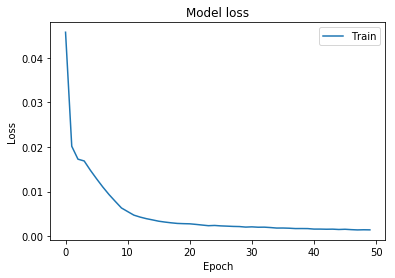

In [119]:
plt.plot(hist.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

With epoc increased to 100, we can even obtain 1.5 ohms accuracy. It seems this neural network model is comparable to the polynominal regressor and meet our needs.

In [120]:
# save model and architecture to single file
nnetMdl.save(workDir + "LStkMdl.h5")

# finally
print("Saved model to disk")

Saved model to disk


## **Deploy:**<a id = 'Deploy'></a>

Using the SESL3 data set as an example, we follow the similar process and built 10+ prediction models for different stakup structure setup. The polynominal model or neural network can be implemented in Java/C++ to avoid dependencies on python's package for distribution purpose. The implemented front-end, shown below, provide a quick and easy method for system designer for stackup/routing planning:
![Deploy](./assets/images/SLSE3Deploy.png)

## **Conclusion:**<a id = 'Conclusion'></a>

In this post/markdown document, we decribe the stackup modeling process using data science/machine learning techniques. The outcome is a deployed front-end with modeled neural network for user's instant performance evaluation. The data set and this markdown document is published on this project's git-hub page.